In [1]:
%cd ../../..


/home/govind/gov_semproject/GridCellsCopy


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.pyplot import cm
import h5py
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from scipy import integrate
from param import Param


In [3]:
params = Param()
lambda_0 = params["lambda0"]

In [8]:
seed=67
np.random.seed(seed)
sim_dur_s=60
sim_dur_s_init = 8 #initial allothetic trajectory duration
allothetic_dur=sim_dur_s_init*1000
Env = Environment(
        params = {'dimensionality':'1D',
                'boundary_conditions':'periodic','scale':lambda_0/100})

#generate allothetic trajectory for 8s (fixed position)
Ag= Agent(Env,
        params = {'dt':0.000025,'speed_mean':0,'speed_std':0}) #0.000025 
Ag.pos=[0]
for i in tqdm(range(int((sim_dur_s_init/Ag.dt)+1))): 
        Ag.update()

#generate rest of the trajectory
Ag.speed_mean= 0.08
Ag.speed_std=0.06
sim_dur_s_traj = sim_dur_s-sim_dur_s_init
for i in tqdm(range(int((sim_dur_s_traj/Ag.dt)+1))): 
        Ag.update()

100%|██████████| 2080001/2080001 [07:17<00:00, 4754.33it/s]


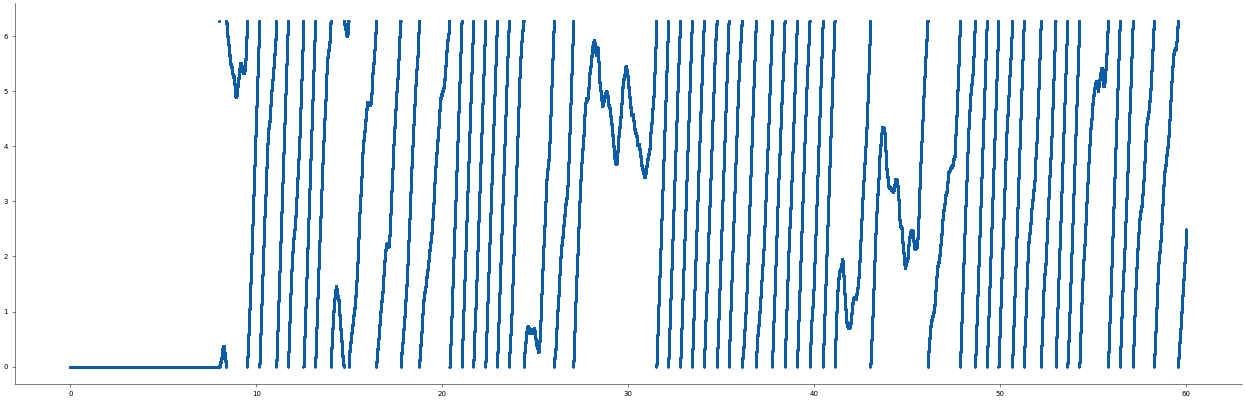

In [9]:
t=np.array(Ag.history['t'])*1000 #s->ms
pos=np.array(Ag.history['pos'])*100 #m-->cm
vel=np.array(Ag.history['vel']).ravel()/10 #m/s --> cm/ms
traj_start_idx = int((sim_dur_s_init)/0.000025)
t=t/1000 #ms-->s
vel=vel*1000
vel[abs(vel)>10]=10 #pin the velocity to 10 since network saturates around 10 rad/s
pos_integrated=integrate.cumulative_trapezoid(vel,t)%(2*np.pi)
plt.style.use("analysis/config/paper.mplstyle")
plt.figure(figsize=(22,7))
plt.scatter(t[:-1],pos_integrated,s=0.5)
plt.show()

In [ ]:
#save trajectory
traj_id ="tmod_rand"
fname="input_data/trajectories/traj_{}.hdf5".format(traj_id)
with h5py.File(fname, 'w') as file:
    file.create_dataset("vel_rinb",  data=vel,compression='gzip')
    file.create_dataset("pos_rinb",data=pos_integrated,compression='gzip')
    file.create_dataset("t_rinb",data=t,compression='gzip')
    file.attrs.create("allothetic_dur",allothetic_dur)
    file.attrs.create("traj_dur",int(sim_dur_s))
    file.attrs.create("traj_params",(Ag.speed_mean,Ag.speed_std,Ag.speed_coherence_time,seed))